In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB1
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D, Activation
import numpy as np
import os
import shutil
import random
import cv2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [2]:
import os
from PIL import Image

# Select an image from the training dataset
train_image_path = os.path.join("dataset/train/dry", os.listdir("dataset/train/dry")[2]) 

# Open the image and get its size
with Image.open(train_image_path) as img:
    width, height = img.size
    print(f"📏 Image Size: {width}x{height}")

📏 Image Size: 640x640


# Image Preprocessing

In [3]:
import os

# Define dataset directories
base_dir = "dataset"  # Replace with the actual path
sets = ["train", "test", "valid"]  # Dataset splits
categories = ["oily", "normal", "dry"]  # Skin types

# Count images in each category for train, test, and validation
for set_name in sets:
    print(f"Dataset: {set_name}")
    num = 0
    for category in categories:
        category_path = os.path.join(base_dir, set_name, category)
        num_images = len(os.listdir(category_path))  # Count number of files
        print(f"  {category.capitalize()}: {num_images} images")
        num += num_images
    print("total images are {num}" )
    print("-" * 30)


Dataset: train
  Oily: 1000 images
  Normal: 1104 images
  Dry: 652 images
total images are {num}
------------------------------
Dataset: test
  Oily: 40 images
  Normal: 59 images
  Dry: 35 images
total images are {num}
------------------------------
Dataset: valid
  Oily: 80 images
  Normal: 111 images
  Dry: 71 images
total images are {num}
------------------------------


In [4]:
# Define paths
train_dir = "dataset/train"
test_dir = "dataset/test"

def preprocess_image(img):
    """ Resize the image to (128,128) without altering other properties """
    img = np.array(img, dtype=np.float32)  # Ensure float32
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_CUBIC)  # High-quality resizing
    return img  # Return unchanged, only resized image


# Define ImageDataGenerator (without additional augmentation)
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)

# Load images from directories
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(128, 128),  # Already resized by preprocessing_function
    batch_size=32,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

print("train data size")
# Get class labels 
class_labels = list(train_data.class_indices.keys())
print(f"Training data size: {train_data.samples} images")  # Use .samples to get the number of images
print(f"Class labels: {class_labels}")

print("test data size")
class_labels = list(test_data.class_indices.keys())
print(f"Test data size: {test_data.samples} images")  # Use .samples
print(f"Class labels: {class_labels}")

Found 2756 images belonging to 3 classes.
Found 134 images belonging to 3 classes.
train data size
Training data size: 2756 images
Class labels: ['dry', 'normal', 'oily']
test data size
Test data size: 134 images
Class labels: ['dry', 'normal', 'oily']


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch of images and labels from train_data
images, labels = next(iter(train_data))  

# Print shape to verify
print(f"Batch Image Shape: {images.shape}")  # Expected: (batch_size, 128, 128, 3)
print(f"Labels Shape: {labels.shape}")  # Expected: (batch_size, number_of_classes)


Batch Image Shape: (32, 128, 128, 3)
Labels Shape: (32, 3)


In [15]:
model = Sequential([
    # First Convolution Block
    Conv2D(32, (3,3), padding='same', kernel_regularizer=l2(0.0005), input_shape=(128, 128, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # Second Convolution Block
    Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # Third Convolution Block
    Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),
    
    Conv2D(256, (3,3), padding='same', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),

    # Use GlobalAveragePooling2D instead of Flatten
    GlobalAveragePooling2D(),

    Dropout(0.3),  # Lower dropout rate
    Dense(64, activation='relu', kernel_regularizer=l2(0.0005)),
    BatchNormalization(),

    Dropout(0.3),
    Dense(3, activation='softmax')  # 3-class classification
])

# Compile the model
optimizer = Adam(learning_rate=0.001)  # Lower learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


C:\Users\yongs\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_13 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_19          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │           19

 Total params: 407,235 (1.55 MB)

 Trainable params: 406,147 (1.55 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [10]:
# Define a simple CNN model
model = Sequential([
    # First Convolution Block
    Conv2D(32, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2,2)),

    # Second Convolution Block
    Conv2D(64, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2,2)),

        # Second Convolution Block
    Conv2D(128, (3,3), padding='same', activation='relu'),
    MaxPooling2D((2,2)),
    
    # Flatten and Fully Connected Layer
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),  # Dropout for regularization
    Dense(3, activation='softmax')  # 3-class classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.005), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
model.build((None, 128,128, 3))
# Model summary
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,288,067 (16.36 MB)

 Trainable params: 4,288,067 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
from sklearn.utils.class_weight import compute_class_weight

# Extract class labels from train_data
y_true = train_data.classes  # Get true labels of training data

history = model.fit(train_data, validation_data=test_data, epochs=20)

Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 285ms/step - accuracy: 0.3910 - loss: 447.2308 - val_accuracy: 0.3955 - val_loss: 1.0909
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 26s 296ms/step - accuracy: 0.4410 - loss: 1.0598 - val_accuracy: 0.4328 - val_loss: 1.0583
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 24s 271ms/step - accuracy: 0.4777 - loss: 1.0103 - val_accuracy: 0.4701 - val_loss: 1.0996
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 25s 291ms/step - accuracy: 0.5444 - loss: 0.9006 - val_accuracy: 0.3806 - val_loss: 1.0832
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 22s 254ms/step - accuracy: 0.5798 - loss: 0.8404 - val_accuracy: 0.3657 - val_loss: 1.2039
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 22s 252ms/step - accuracy: 0.6257 - loss: 0.7812 - val_accuracy: 0.4030 - val_loss: 1.2783
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 22s 254ms/step - accuracy: 0.6459 - loss: 0.7055 - val_accuracy: 0.3881 - val_loss: 1.1870
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 22s 252ms/step - accuracy: 0.7122 - loss: 0.6071 - val_ac

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step


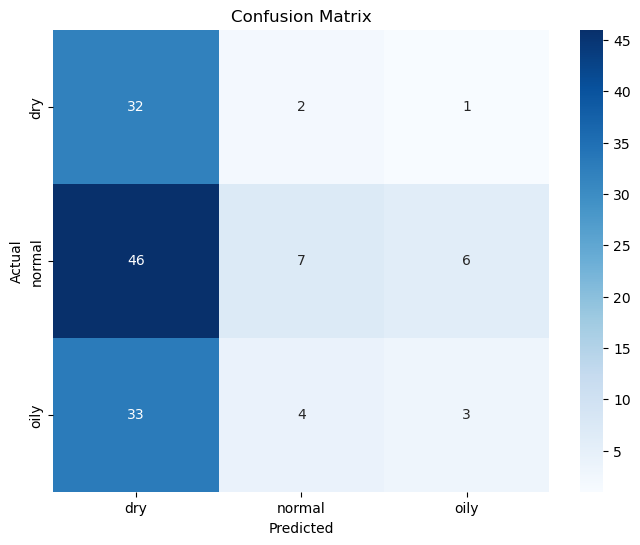

              precision    recall  f1-score   support

         dry       0.29      0.91      0.44        35
      normal       0.54      0.12      0.19        59
        oily       0.30      0.07      0.12        40

    accuracy                           0.31       134
   macro avg       0.38      0.37      0.25       134
weighted avg       0.40      0.31      0.24       134



In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get true labels and predictions
y_true = test_data.classes
y_pred = np.argmax(model.predict(test_data), axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=class_labels))

# cross validation
